In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np

from climada.hazard import Hazard

tc_wind = Hazard.from_hdf5("./data/tc_wind/tc_wind_SHANSHAN_20240825000000.hdf5")
tc_wind.frequency = np.ones(len(tc_wind.frequency))/51 # change frequency to get the ensemble mean

In [4]:
import numpy as np
from climada.util.coordinates import get_country_code

idx_non_zero_wind = tc_wind.intensity.max(axis=0).nonzero()[1]

country_code_all = get_country_code(tc_wind.centroids.lat[idx_non_zero_wind], 
                                    tc_wind.centroids.lon[idx_non_zero_wind])
country_code_unique = np.trim_zeros(np.unique(country_code_all))


In [5]:
from climada.entity import ImpactFunc, ImpactFuncSet

def impf_step_func(threshold: float = 32.92):

    impf = ImpactFunc.from_step_impf((0,threshold, 100),
                                     haz_type="TC")
    
    impf_set = ImpactFuncSet()
    impf_set.append(impf)

    return(impf_set)

In [6]:
from climada.engine import ImpactCalc
from climada.util.api_client import Client
from climada.util.coordinates import country_to_iso
client = Client()

impf_set_step = impf_step_func()

imp_per_country_dict = {}

for country_code in country_code_unique:
    try:
        exp = client.get_exposures(exposures_type='litpop',
                                properties={'country_iso3num':[str(country_code)],
                                            'exponents':'(0,1)',
                                            'fin_mode':'pop',
                                            'version':'v2'
                                            }
                                )
    except client.NoResult:
        f"there is no matching dataset in Data API. Country code: {country_code}"
    
    imp_exposed = ImpactCalc(exp, impf_set_step, tc_wind).impact()

    if imp_exposed.aai_agg == 0.0:
        continue
    else:
        imp_per_country_dict[country_to_iso(country_code, "alpha3")] = imp_exposed

2024-11-27 15:56:11,840 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1572514 coordinates.
2024-11-27 15:56:11,947 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 6905 coordinates.


In [7]:
imp_per_country_dict

{'JPN': <climada.engine.impact.Impact at 0x1561e4f90>,
 'RUS': <climada.engine.impact.Impact at 0x16a22bb50>}

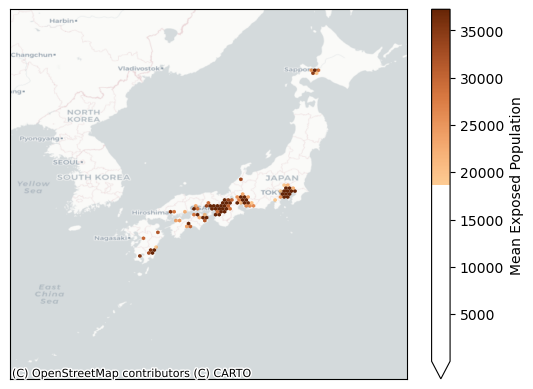

In [102]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm_mp
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import contextily as ctx

from climada.util.constants import CMAP_IMPACT, CMAP_EXPOSURES

imp_exp_all = imp_per_country_dict['JPN']._build_exp()
imp_exp_all.set_geometry_points()
#imp_exp =imp_exp_all.gdf[imp_exp_all.gdf.value>0.]

cmap = plt.get_cmap("YlOrBr")
cmap.set_bad("white", alpha=0)
cmap.set_under("white", alpha=0)


fig, ax = plt.subplots()

extent = imp_exp_all.gdf.geometry.to_crs(epsg=3857).total_bounds
imp_exp_all.to_crs("EPSG:3857", inplace=True)
gdf = imp_exp_all.gdf

vmax = np.max(gdf["value"])
vmin = 10 if vmax > 10 else 1
vmax = 10 if vmax < 2 else vmax
extend = "min" if np.min(gdf["value"]) < vmin else None
norm = Normalize(vmin=vmin, vmax=vmax)

colors = cmap(np.arange(cmap.N))
colors[:, -1] = np.linspace(0.0, 1.0, cmap.N)

# Make low values transparent
threshold = vmin
colors[:int(threshold / 20 * cmap.N), -1] = 0.0

transparent_cmap = ListedColormap(colors)

hb = ax.hexbin(
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        C=gdf["value"],
        reduce_C_function=np.sum,
        norm=norm,
        gridsize=100,
        extent=(extent[0], extent[2], extent[1], extent[3]),
        lw=0.0,
        cmap=transparent_cmap,
        )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.colorbar(hb, ax=ax, label="Mean Exposed Population", extend=extend)

# vmax = np.max(hb.get_array())
# vmin = 10 if vmax > 10 else 1
# vmax = 10 if vmax < 2 else vmax
# norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
# extend = "min" if np.min(cm.get_array()) < vmin else None
# hb.set_norm(norm)




# Add basemaps
#ctx.add_basemap(
#    ax=ax,
#    source=ctx.providers.CartoDB.Voyager,
#)
# mappable = ax.hexbin(imp_exp.gdf.geometry.y, imp_exp.gdf.geometry.x, C=imp_exp.gdf.value, cmap=CMAP_EXPOSURES)

